#Importing Modules


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
sns.set()

# importing torch and modules
import torch
import torchvision as TV
from torchvision.io import read_image
from torchvision.io import write_png

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preprocessing

In [ ]:
TRAIN_SET = 5235

Experimenting on few random images

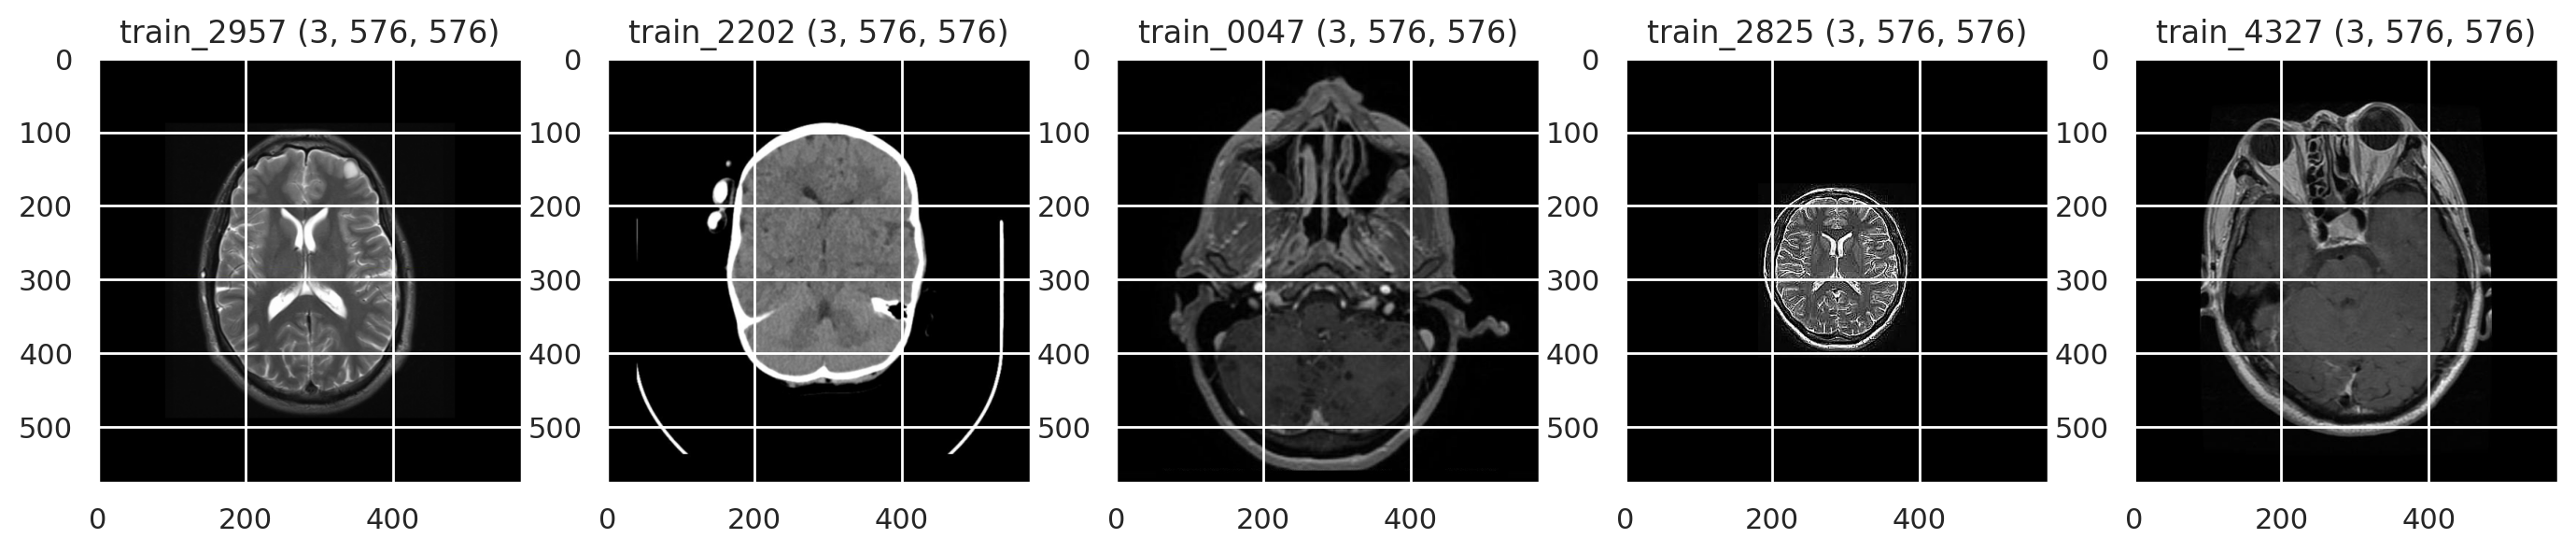

In [ ]:
idx = np.random.randint(0, TRAIN_SET, 5)

plt.figure(figsize = (17,8))

num=1
for i in idx:
  img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png', 'RGB')
  a, b, c = img.shape

  pic = TV.transforms.ToPILImage()(img)

  plt.subplot(1, 5, num)
  num+=1

  plt.title(f'train_{i:04d} ({a}, {b}, {c})')

  plt.imshow(pic)

Resizing these randomly sampled images to (3, 576, 576) by padding/cropping.

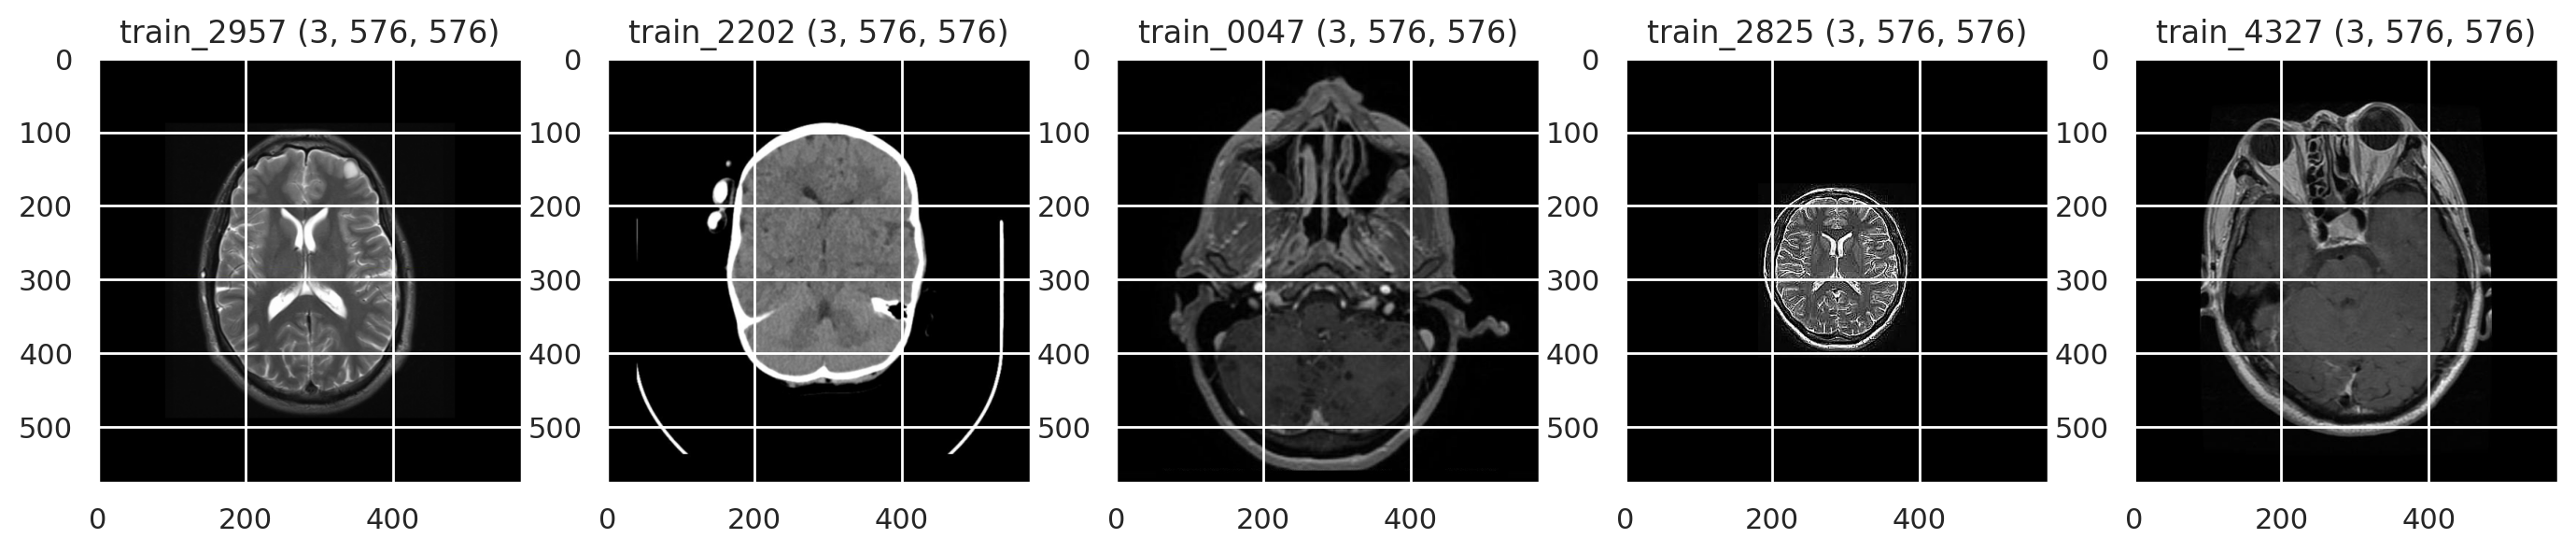

In [ ]:
plt.figure(figsize = (17,8))
num=1
for i in idx:
  img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png', 'RGB')

  pic = np.zeros((3, 576, 576))
  img = TV.transforms.functional.center_crop(img, (576, 576))
  pic = img

  a, b, c = pic.shape

  pic = TV.transforms.ToPILImage()(pic)

  plt.subplot(1, 5, num)
  num+=1

  plt.title(f'train_{i:04d} ({a}, {b}, {c})')

  plt.imshow(pic)

===> The result seems very good and brings consistency in the resolution of examples.

We can apply this change to all examples of the train and test set.

##Cropping images to make the dimensions same.

In [ ]:
for i in np.arange(1, TRAIN_SET+1):
  img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png', 'RGB')

  pic = np.zeros((3, 576, 576))
  img = TV.transforms.functional.center_crop(img, (576, 576))
  pic = img

  write_png(pic, f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png')

Now all the images in the train set are of the same dimensions.

Applying the same to test set.

In [ ]:
for i in np.arange(1, 37):
  img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test/test_{i:04d}.png', 'RGB')

  pic = np.zeros((3, 576, 576))
  img = TV.transforms.functional.center_crop(img, (576, 576))
  pic = img

  write_png(pic, f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test/test_{i:04d}.png')

print("Execution Successful!")

Execution Successful!


===> Now all the images in the dataset are of same resolution.

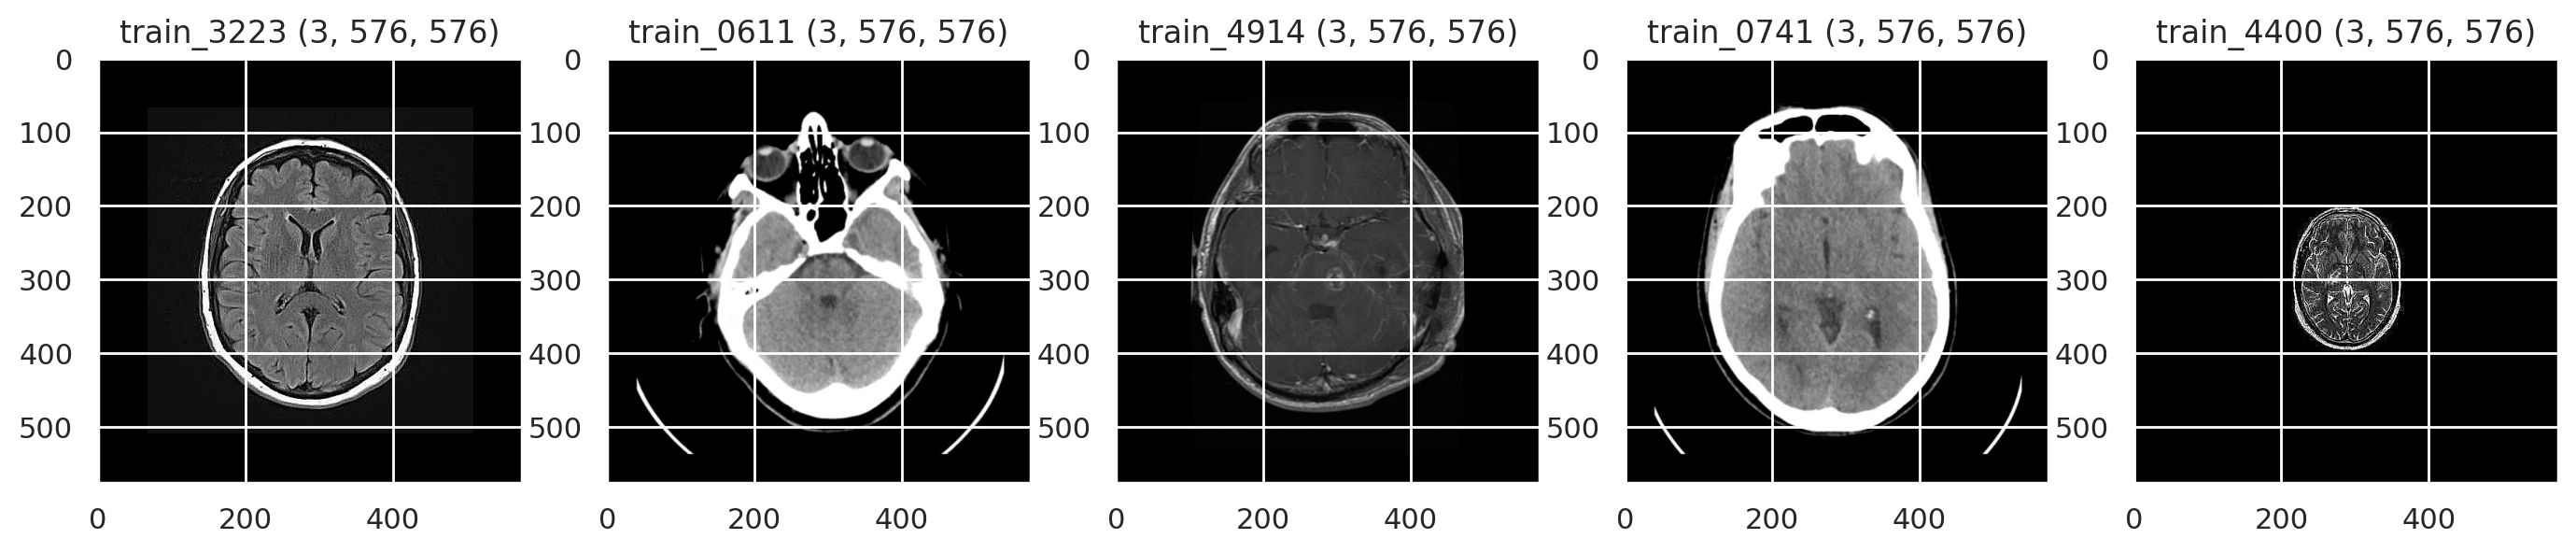

In [ ]:
idx = np.random.randint(0, TRAIN_SET, 5)

plt.figure(figsize = (17,8))

num=1
for i in idx:
  img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png', 'RGB')
  a, b, c = img.shape

  pic = TV.transforms.ToPILImage()(img)

  plt.subplot(1, 5, num)
  num+=1

  plt.title(f'train_{i:04d} ({a}, {b}, {c})')

  plt.imshow(pic)

##Motion Blur

In [ ]:
def gen_blur_kernel(ksize, thickx, thicky):
  '''Generates motion blurring kernels
     of size=ksize; with a lie vertical or
     horizontal of specified thickness'''
  blur_kernel = torch.zeros((ksize, ksize))
  midpix = ksize/2

  #vertical line
  blur_kernel[:, (int)(midpix-thickx/2):(int)(midpix+thickx/2)] = torch.ones((ksize, thickx))

  #horizontal line
  blur_kernel[(int)(midpix-thicky/2):(int)(midpix+thicky/2), :] = torch.ones((thicky, ksize))

  return blur_kernel

In [ ]:
def gen_dig_blur_kernel(ksize, orientation):
  '''Generates a motion kernel with a diagonal white line
     for diagonal blurring.'''

  blur_kernel = torch.zeros((ksize, ksize))

  for i in range(ksize):
    if orientation=='left':
      blur_kernel[i, i] = 1
    else:
      blur_kernel[i, ksize-i-1] = 1

  return blur_kernel

In [ ]:
kernels = []
ksize = [11, 15, 21, 25, 31, 41]

unit_thick = 1
null_thick = 0

for k in range(len(ksize)):
  # two kernels for horizontal and vertical blurring
  two_kernels = [gen_blur_kernel(ksize[k], unit_thick, null_thick), gen_blur_kernel(ksize[k], null_thick, unit_thick)]
  kernels.append(two_kernels)

  # two kernels for diagonal blurring
  two_dig_kernels = gen_dig_blur_kernel(ksize[k], 'left')
  kernels[k].append(two_dig_kernels)
  two_dig_kernels = gen_dig_blur_kernel(ksize[k], 'right')
  kernels[k].append(two_dig_kernels)

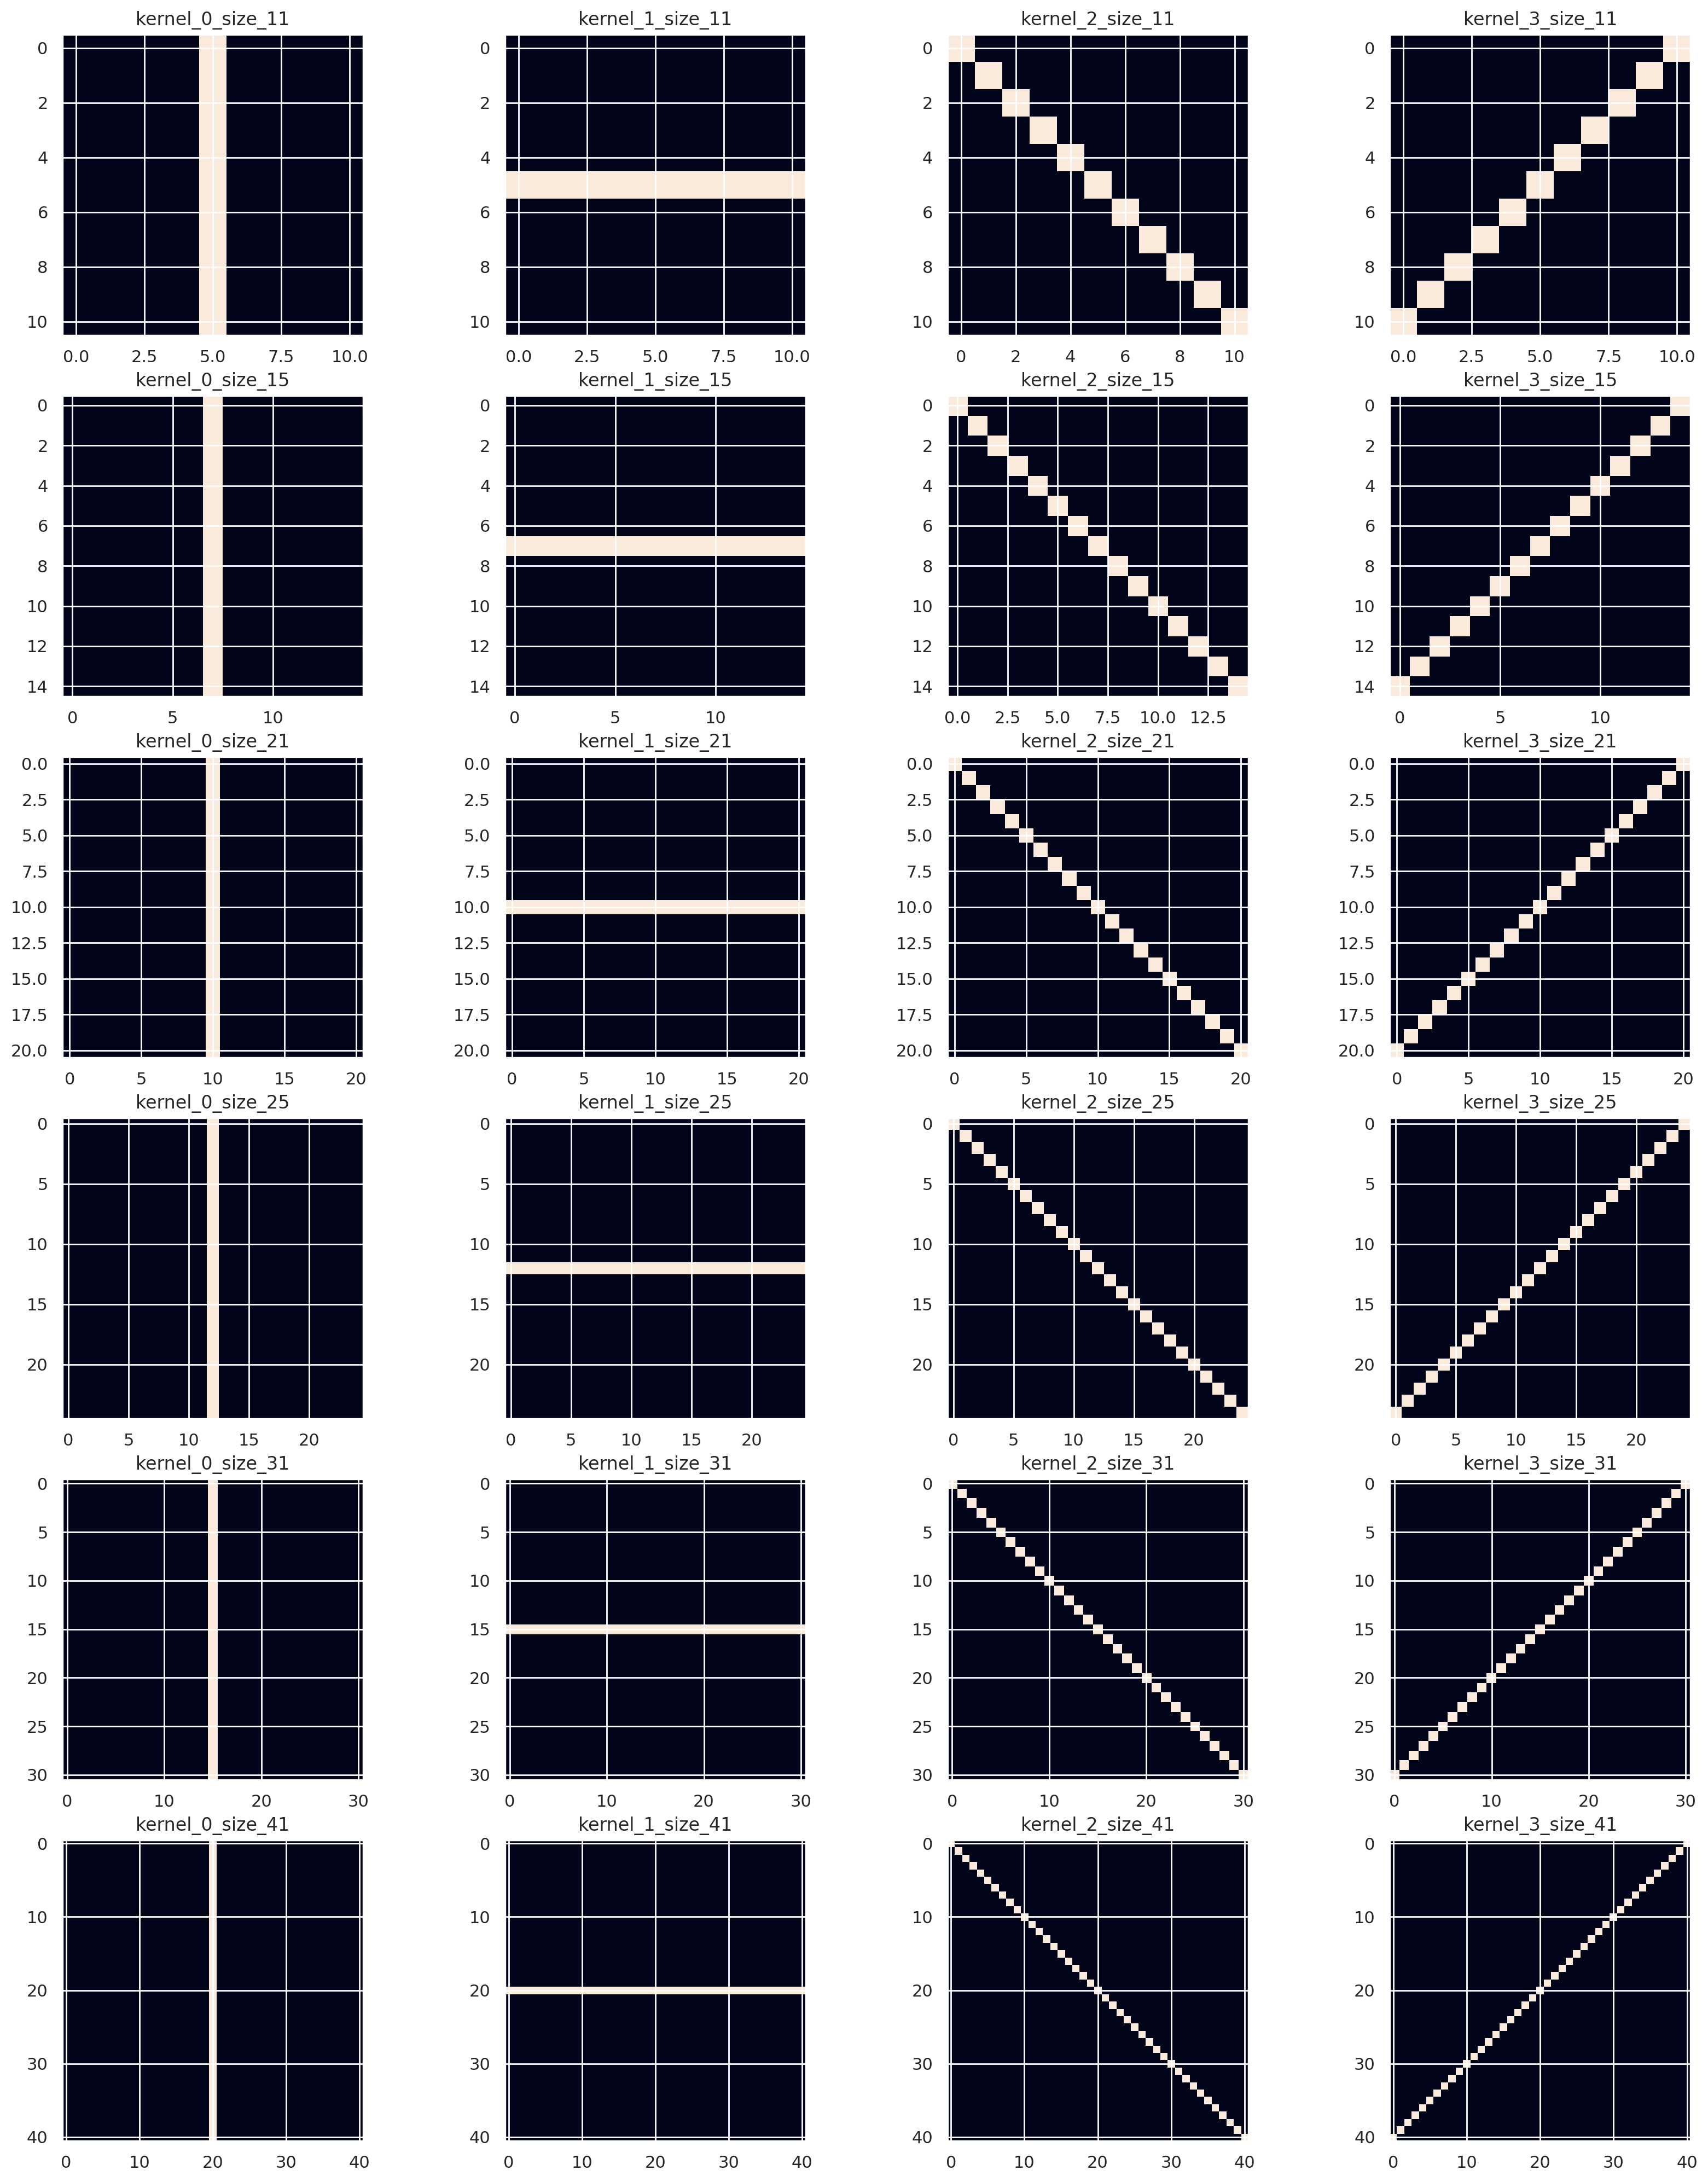

In [ ]:
plt.figure(figsize=(20, 25))
num=1

for k in range(len(ksize)):
  for i in range(len(kernels[k])):
    blur_kernel = kernels[k][i]

    plt.subplot(len(ksize), len(kernels[0]), num)
    num+=1
    plt.title(f'kernel_{i}_size_{ksize[k]}')
    plt.imshow(kernels[k][i])

Testing above blur kernels on a random image

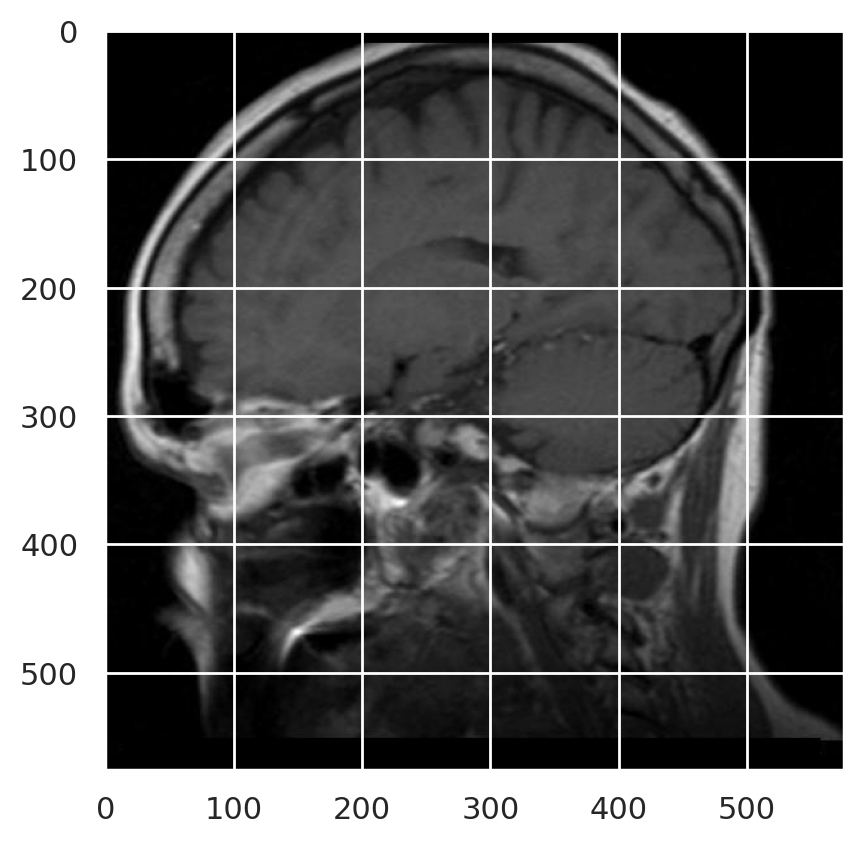

In [ ]:
test_img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{17:04d}.png', 'RGB')
test_img = TV.transforms.ToPILImage()(test_img)
plt.imshow(test_img)

In [ ]:
plt.figure(figsize = (20, 25))
num=1

for k in range(len(ksize)):
  for i in range(len(kernels[k])):
    blur_kernel = kernels[k][i].reshape(1, 1, ksize[k], ksize[k])
    blur_kernel = blur_kernel.repeat(3, 1, 1, 1)

    # normalizing to keep the brightness of the image same
    blur_kernel /= torch.count_nonzero(kernels[k][i])

    img = TV.transforms.ToTensor()(test_img).reshape(1, 3, 576, 576)

    # groups = C_in so convolution is depthwise
    motion_blurred_image = torch.nn.functional.conv2d(img, blur_kernel, padding=ksize[k]//2, groups=3)

    motion_blurred_image = motion_blurred_image.reshape(3, 576, 576)
    motion_blurred_image = TV.transforms.ToPILImage()(motion_blurred_image)

    plt.subplot(len(ksize), len(kernels[0]), num)
    num+=1
    plt.title(f'kernel_{i}_size_{ksize[k]}')
    plt.imshow(motion_blurred_image)

Output hidden; open in https://colab.research.google.com to view.

===> We can easily observe effect of increasing kernel size. Optimal sizes of kernel can also be picked from the above plots.

Applying this effect on train set images to produce corresponding motion blurred images that will be used for training.

In [ ]:
kernels = []
# final kernel sizes
ksize = [15, 21, 25, 31]

unit_thick = 1
null_thick = 0

for k in range(len(ksize)):
  # two kernels for horizontal and vertical blurring
  two_kernels = [gen_blur_kernel(ksize[k], unit_thick, null_thick), gen_blur_kernel(ksize[k], null_thick, unit_thick)]
  kernels.append(two_kernels)

  # two kernels for diagonal blurring
  two_dig_kernels = gen_dig_blur_kernel(ksize[k], 'left')
  kernels[k].append(two_dig_kernels)
  two_dig_kernels = gen_dig_blur_kernel(ksize[k], 'right')
  kernels[k].append(two_dig_kernels)

In [ ]:
# will update this array to monitor the distribution of kernel size and blurring orientation.
monitoring_distribution = np.zeros((4, 4))

In [ ]:
%%time
for i in np.arange(1, 5236, 1):

  if(i%500 == 0):
    print(f"===Completed upto train_{i:04d}.png===")
    print()

  # picking the kernel size and orientation of blur randomly.
  int1 = np.random.randint(0, 4, 1)[0]
  int2 = np.random.randint(0, 4, 1)[0]

  monitoring_distribution[int1][int2] += 1

  blur_kernel = kernels[int1][int2].reshape(1, 1, ksize[int1], ksize[int1])
  blur_kernel = blur_kernel.repeat(3, 1, 1, 1)

  # normalizing to keep the brightness of the image same
  blur_kernel /= torch.count_nonzero(kernels[int1][int2])

  working_img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{i:04d}.png', 'RGB')

  img = working_img.reshape(1, 3, 576, 576).float()

  # sending the image and kernel to gpu
  img = img.to(device)
  blur_kernel = blur_kernel.to(device)

  # groups = C_in so convolution is depthwise
  motion_blurred_image = torch.nn.functional.conv2d(img, blur_kernel, padding=ksize[int1]//2, groups=3)

  # typecasting to uint8 as expected by write_png
  motion_blurred_image = motion_blurred_image.reshape(3, 576, 576).byte()

  motion_blurred_image = motion_blurred_image.to("cpu")

  write_png(motion_blurred_image, f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train/blurred_train_{i:04d}.png')

print("Execution Successful!\n")

===Completed upto train_0500.png===

===Completed upto train_1000.png===

===Completed upto train_1500.png===

===Completed upto train_2000.png===

===Completed upto train_2500.png===

===Completed upto train_3000.png===

===Completed upto train_3500.png===

===Completed upto train_4000.png===

===Completed upto train_4500.png===

===Completed upto train_5000.png===

Execution Successful!

CPU times: user 3min 56s, sys: 3.84 s, total: 3min 59s
Wall time: 39min


Doing the same for test images to produce corresponding motion blurred images.

In [ ]:
%%time
for i in np.arange(1, 37, 1):

  # picking the kernel size and orientation of blur randomly.
  int1 = np.random.randint(0, 4, 1)[0]
  int2 = np.random.randint(0, 4, 1)[0]

  blur_kernel = kernels[int1][int2].reshape(1, 1, ksize[int1], ksize[int1])
  blur_kernel = blur_kernel.repeat(3, 1, 1, 1)

  # normalizing to keep the brightness of the image same
  blur_kernel /= torch.count_nonzero(kernels[int1][int2])

  working_img = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/test/test_{i:04d}.png', 'RGB')

  img = working_img.reshape(1, 3, 576, 576).float()

  # sending the image and kernel to gpu
  img = img.to(device)
  blur_kernel = blur_kernel.to(device)

  # groups = C_in so convolution is depthwise
  motion_blurred_image = torch.nn.functional.conv2d(img, blur_kernel, padding=ksize[int1]//2, groups=3)

  # typecasting to uint8 as expected by write_png
  motion_blurred_image = motion_blurred_image.reshape(3, 576, 576).byte()

  motion_blurred_image = motion_blurred_image.to("cpu")

  write_png(motion_blurred_image, f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_test/blurred_test_{i:04d}.png')

print("Execution Successful!\n")

Execution Successful!

CPU times: user 1.57 s, sys: 23.8 ms, total: 1.6 s
Wall time: 15.6 s


===> Now we have original and corresponding motion blurred images for our entire dataset.

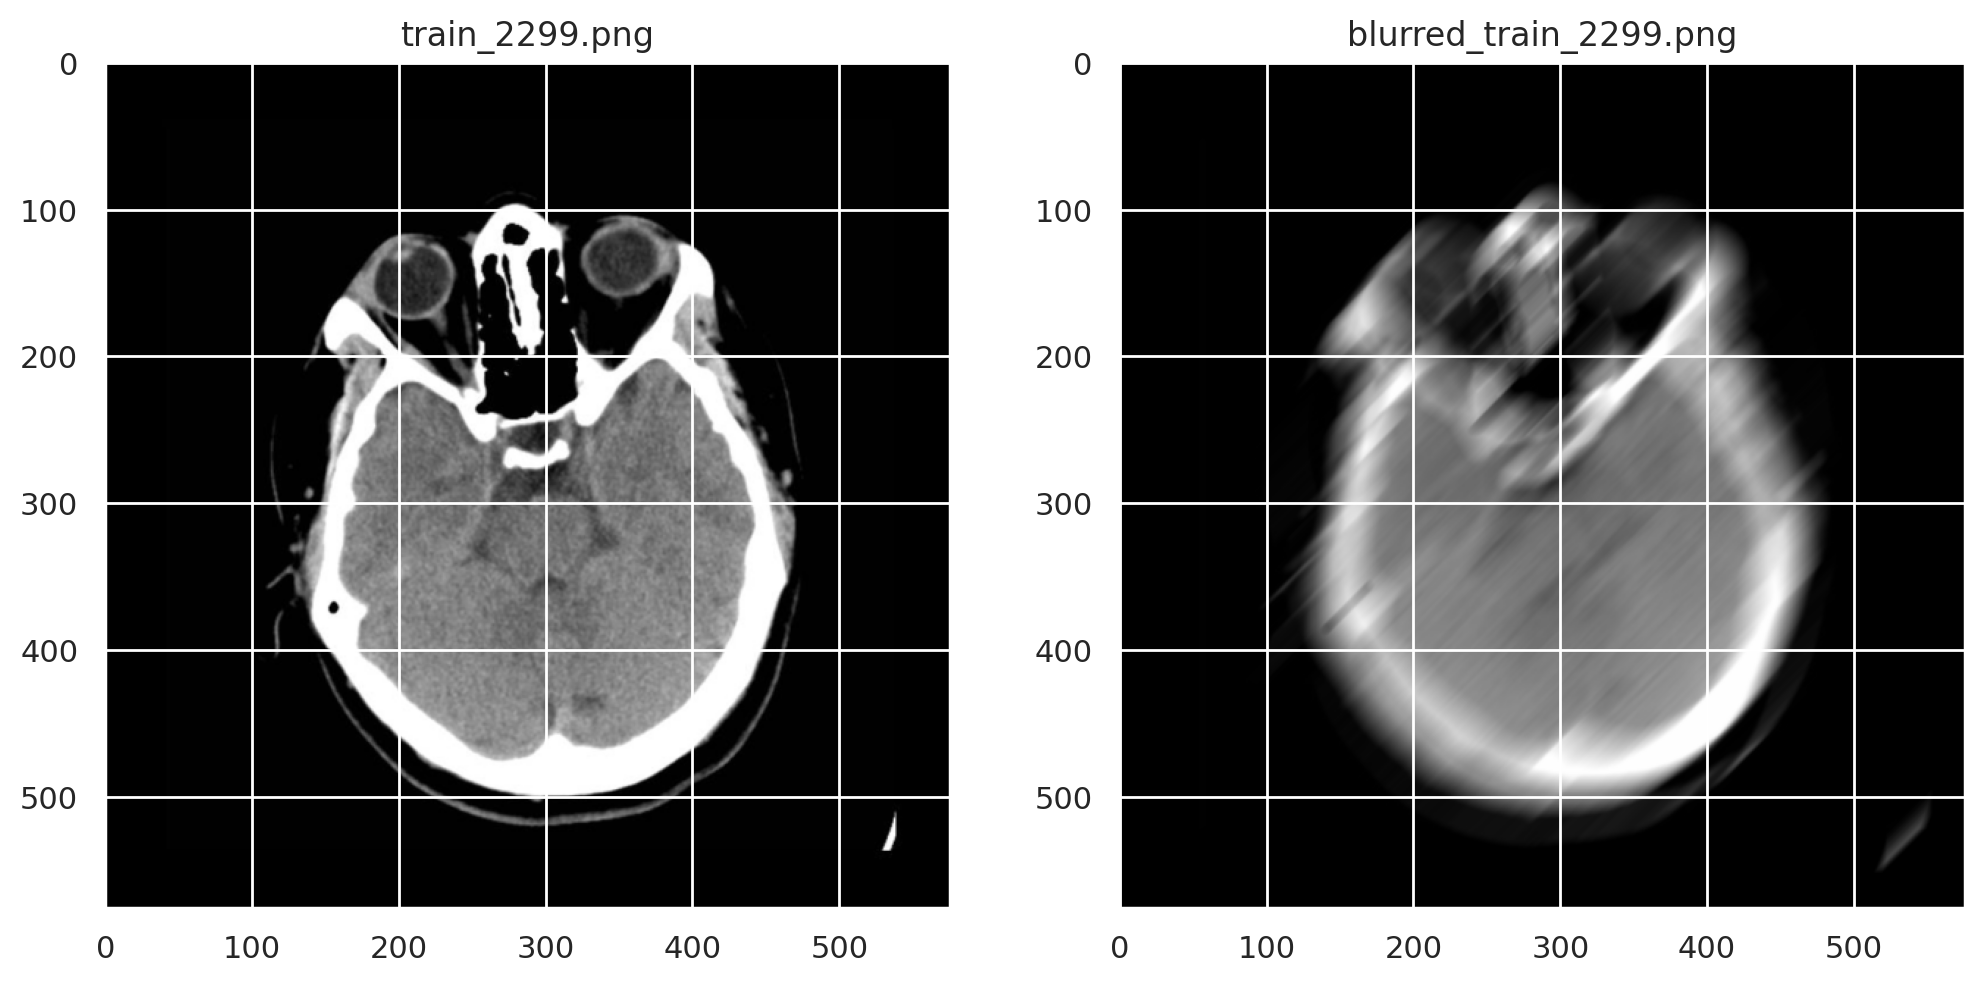

In [ ]:
random_img = np.random.randint(1, 5236, 1)[0]

plt.figure(figsize=(12, 10))

# random train image
plt.subplot(1, 2, 1)
img1 = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/train/train_{random_img:04d}.png', 'RGB')
img1 = TV.transforms.ToPILImage()(img1)
plt.title(f'train_{random_img:04d}.png')
plt.imshow(img1)

#corresponding blurred image
plt.subplot(1, 2, 2)
img2 = read_image(f'/content/drive/MyDrive/Restoring Brain CT and Brain MRI/data/Images/blurred_train/blurred_train_{random_img:04d}.png', 'RGB')
img2 = TV.transforms.ToPILImage()(img2)
plt.title(f'blurred_train_{random_img:04d}.png')
plt.imshow(img2)

plt.show()

In [ ]:
np.sum(monitoring_distribution, axis=1)

array([1290., 1303., 1324., 1318.])

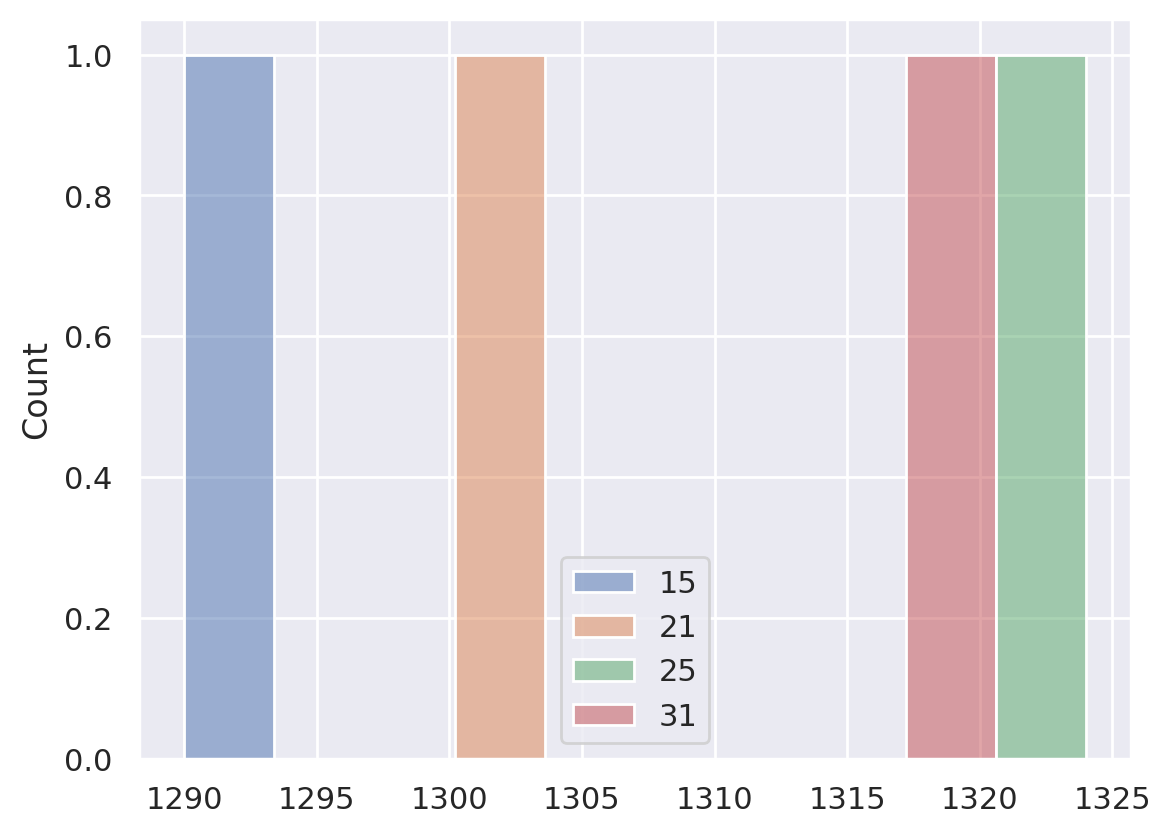

In [ ]:
sns.histplot(x=np.sum(monitoring_distribution, axis=1), bins = 10, hue=[str(k) for k in ksize])
plt.show()

In [ ]:
np.sum(monitoring_distribution, axis=0)

array([1297., 1316., 1326., 1296.])

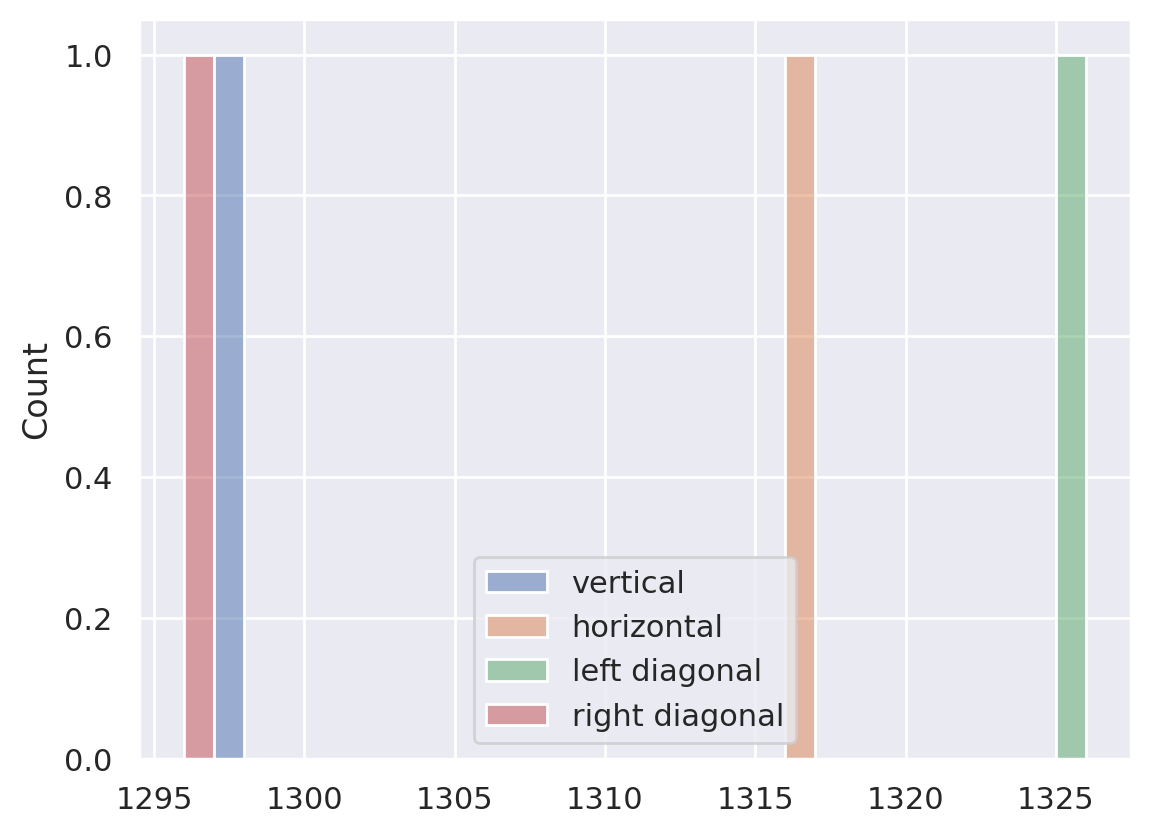

In [ ]:
sns.histplot(x=np.sum(monitoring_distribution, axis=0), bins=30, hue=['vertical', 'horizontal', 'left diagonal', 'right diagonal'])
plt.show()

The count is not very far away. Bigger kernel size occurs more so the blurring in the images is definietly more and same for orientation of blurring where more images are left diagonally blurred.

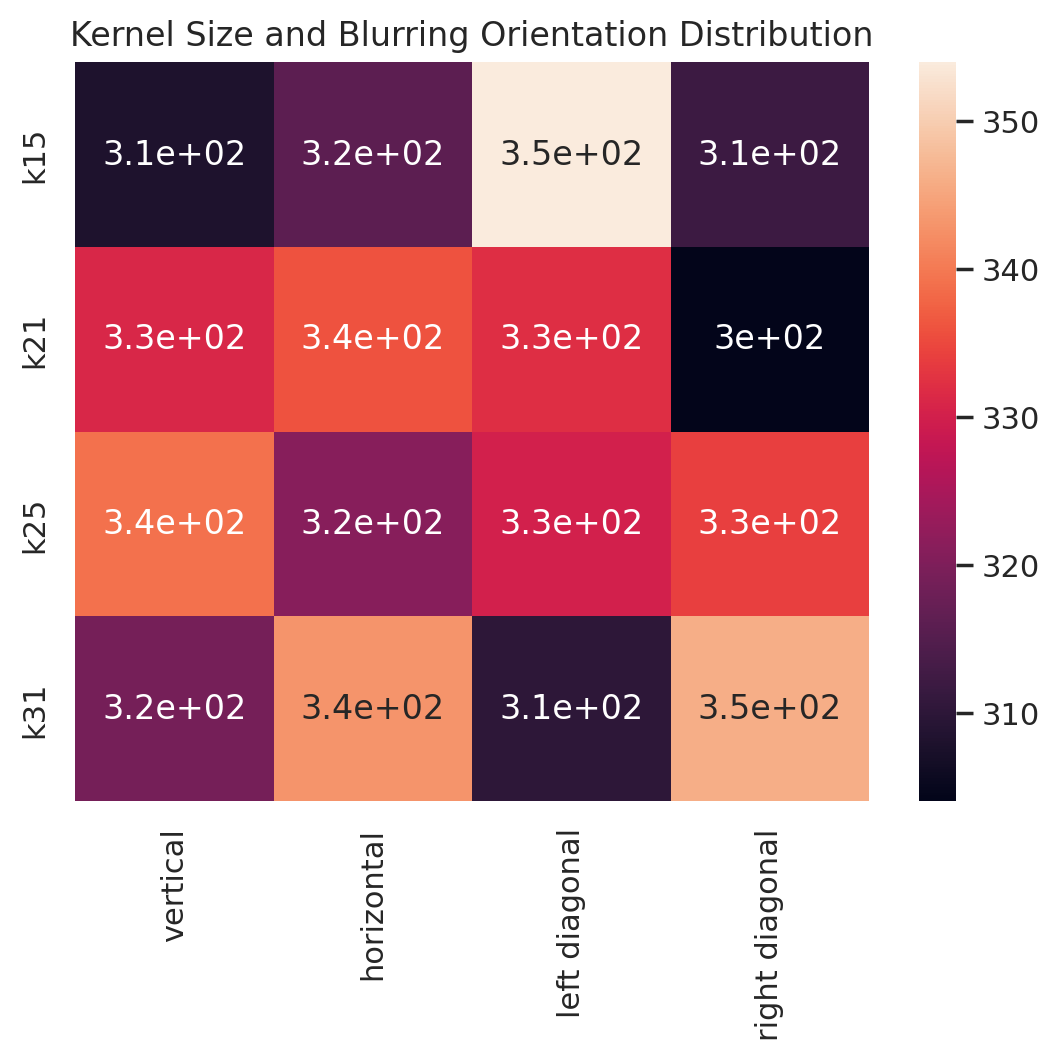

In [ ]:
sns.heatmap(monitoring_distribution, xticklabels=['vertical', 'horizontal', 'left diagonal', 'right diagonal'], yticklabels=['k' + str(k) for k in ksize], annot=True)
plt.title('Kernel Size and Blurring Orientation Distribution')
plt.show()

===> Hence the data does not contain any kind of repeated pattern and blurring is very random.